<a href="https://colab.research.google.com/github/Eugikats/student-retention-prediction/blob/main/Group_9_Final_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Recap and Target/Features

Stanford's Sentiment Treebank (SST-2) is a binary text classification problem focusing on sentiment analysis. The goal is to predict the sentiment of a given movie review sentence as positive or negative.


Target Variable (y): The overall sentiment of the sentence – labeled positive (1) or negative (0).


Input Feature (X): The text of the movie review sentence itself. Each data point is one sentence (or phrase) from a Rotten Tomatoes review.

**Group Members**

Eugene Katusiime

Stephen Njuki

Joshua Kayongo

Akwi Tracy Aidah

Higenyi Yurri

Nabuyondo Hamirat Shibah

Alex Wadaba

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from tensorflow.keras.callbacks import EarlyStopping

# Clustering / visualization
from scipy.cluster.hierarchy import linkage, dendrogram

# Imbalanced learning
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Description

For this project, we used the **UWIZA 2015 dataset**, a socio-economic and education-focused survey conducted in Uganda. The dataset is particularly relevant to our research objective of predicting school dropout, as it contains rich information at **household, school, and village levels**.

The raw data was provided in three files:

- **Household data (`ug15_hhld.csv`)** – demographic characteristics, education levels, household composition, assets, and living conditions.  
- **School data (`ug15_school.csv`)** – school attendance, grade progression, and related factors.  
- **Village data (`ug15_village.csv`)** – community-level indicators such as infrastructure and services.  

After merging these datasets on common identifiers (household, district, village, and region), the combined dataset contained **47,048 records and 456 variables**. From this, we selected a subset of **30 features** most relevant to dropout prediction, covering:

- **Individual-level features:** age, gender, disability, biological parents, mother’s education, mother’s schooling history.  
- **Household-level features:** household size, composition, head’s age/gender/education, and assets (TV, radio, phone, bicycle, livestock, etc.).  
- **Environmental features:** water source, sanitation, urban/rural code, district and region names.  

The **target variable** is `dropout`, a binary label indicating whether a student dropped out (“Yes”) or remained in school (“No”).  

Since the original dataset was imbalanced, we balanced it by sampling equal numbers of cases from both classes. The final analysis dataset contains **1,948 observations** (974 “Yes” and 974 “No”) and **30 features**, providing a manageable yet diverse set of socio-economic, demographic, and educational variables for modeling.  


In [3]:
# Define paths
base_path = "/content/drive/MyDrive/Classroom/Group 9/Final Group Assignment/"
path_hh = f"{base_path}ug15_hhld.csv"
path_school = f"{base_path}ug15_school.csv"
path_village = f"{base_path}ug15_village.csv"

In [4]:
# Load random sample
sample_size = 20000
df_hh = pd.read_csv(path_hh, low_memory=False).sample(n=sample_size, random_state=42)
df_school = pd.read_csv(path_school, low_memory=False).sample(n=sample_size, random_state=42)
df_village = pd.read_csv(path_village, low_memory=False).sample(n=sample_size, random_state=42)

# Quick preview
print(df_hh.shape, df_school.shape, df_village.shape)
print(df_hh.head(), df_school.head(), df_village.head())

(20000, 156) (20000, 156) (20000, 156)
       id_database  id_district id_districtName    id_hh id_regionName  \
40381         UG15          226         Buyende  1478006       Eastern   
20123         UG15          201          Bugiri   739017       Eastern   
40280         UG15          226         Buyende  1493011       Eastern   
134936        UG15          231           Ngora  1626020       Eastern   
155826        UG15          215         Sironko  1164010       Eastern   

        id_village  county_code1          county  parishcode  subcounty_code  \
40381         1478             1         BUDIOPE           9               1   
20123          739             1  BUKOOLI  NORTH           9               8   
40280         1493             1         BUDIOPE           4               6   
134936        1626             1           NGORA          14               1   
155826        1164             1        BUDADIRI           2              19   

        ... noHhldsInEA noEAsInDist

In [5]:
# Merge Datasets
merge_keys = ["id_database","id_district","id_districtName","id_hh","id_regionName","id_village"]

df_hh_school = df_hh.merge(df_school, on=merge_keys, suffixes=('_hh','_sch'))
df_master = df_hh_school.merge(df_village, on=merge_keys, suffixes=('', '_vill'))

print("Merged shape:", df_master.shape)
print(df_master.columns.tolist())

Merged shape: (47048, 456)
['id_database', 'id_district', 'id_districtName', 'id_hh', 'id_regionName', 'id_village', 'county_code1_hh', 'county_hh', 'parishcode_hh', 'subcounty_code_hh', 'subcounty_name_hh', 'parish_name_hh', 'locationcode_hh', 'location_hh', 'ea_code_hh', 'eacode_hh', 'village_estate_hh', 'urban_code_hh', 'no_of_hhs_hh', 'males_hh', 'females_hh', 'sample_no_hh', 'ea_code1_hh', 'validationcode_hh', 'date_hh', 'hhno_hh', 'answering_person_hh', 'hh_gender_hh', 'hh_age_hh', 'hh_edu_raw_hh', 'household_visited_hh', 'whichyear_hh', 'home_language_hh', 'hh_size_hh', 'hh_males_hh', 'hh_females_hh', 'house_wall_hh', 'house_lighting_hh', 'asset_toilet_hh', 'mealsPerDay_hh', 'eat_veg_hh', 'eat_fruit_hh', 'drink_milk_hh', 'asset_tv_hh', 'asset_radio_hh', 'asset_computer_hh', 'asset_phone_hh', 'asset_car_hh', 'asset_motorbike_hh', 'asset_bicycle_hh', 'asset_cattle_hh', 'asset_sheep_goat_hh', 'h107_donkey_hh', 'h107_camel_hh', 'h107_pig_hh', 'h107other_hh', 'water_source_hh', 'wate

In [6]:
# Feature and target selection
selected_cols = [
    "dropout", "age", "gender", "disability", "biological_parents",
    "mothers_edu", "mothers_toschool", "hh_edu", "hh_gender", "hh_age",
    "hh_size", "hh_males", "hh_females", "asset_tv", "asset_radio",
    "asset_computer", "asset_phone", "asset_car", "asset_motorbike",
    "asset_bicycle", "asset_cattle", "asset_sheep_goat", "asset_elec",
    "asset_water", "asset_toilet", "water_source", "water_source_distance",
    "id_regionName", "id_districtName", "urban_code"
]

available_cols = [col for col in selected_cols if col in df_master.columns]
df_filtered = df_master[available_cols].copy()

# Drop rows with missing target and keep Yes/No only
df_filtered = df_filtered.dropna(subset=["dropout"])
df_filtered = df_filtered[df_filtered["dropout"].isin(["Yes", "No"])]


In [7]:
# Separate classes
df_yes = df_filtered[df_filtered["dropout"] == "Yes"]
df_no  = df_filtered[df_filtered["dropout"] == "No"]

# Sample each class for balance
n_samples = min(len(df_yes), len(df_no), 1000)  # adjust 1000 if needed
df_yes_balanced = df_yes.sample(n_samples, random_state=42)
df_no_balanced  = df_no.sample(n_samples, random_state=42)

# Combine and shuffle
df_final = pd.concat([df_yes_balanced, df_no_balanced]).sample(frac=1, random_state=42)

# Check
print("Final dataset shape:", df_final.shape)
print(df_final["dropout"].value_counts())

# Save
df_final.to_csv(f"{base_path}df_final.csv", index=False)

Final dataset shape: (1948, 30)
dropout
No     974
Yes    974
Name: count, dtype: int64


In [8]:
print(df_final.columns.tolist())

['dropout', 'age', 'gender', 'disability', 'biological_parents', 'mothers_edu', 'mothers_toschool', 'hh_edu', 'hh_gender', 'hh_age', 'hh_size', 'hh_males', 'hh_females', 'asset_tv', 'asset_radio', 'asset_computer', 'asset_phone', 'asset_car', 'asset_motorbike', 'asset_bicycle', 'asset_cattle', 'asset_sheep_goat', 'asset_elec', 'asset_water', 'asset_toilet', 'water_source', 'water_source_distance', 'id_regionName', 'id_districtName', 'urban_code']


## EDA
By Alex Wadaba

In [9]:
# Step 1: Basic Overview
print("Shape of dataset:", df_final.shape)
print("\nMissing values per column:\n", df_final.isna().sum())
print("\nSummary statistics (numerical features):\n", df_final.describe())

Shape of dataset: (1948, 30)

Missing values per column:
 dropout                    0
age                        0
gender                     0
disability                11
biological_parents        13
mothers_edu              835
mothers_toschool         159
hh_edu                   537
hh_gender                 38
hh_age                   182
hh_size                    4
hh_males                  14
hh_females                43
asset_tv                   0
asset_radio                0
asset_computer             0
asset_phone                0
asset_car                  0
asset_motorbike            0
asset_bicycle              0
asset_cattle               0
asset_sheep_goat           0
asset_elec                 0
asset_water                0
asset_toilet               0
water_source              22
water_source_distance     27
id_regionName              0
id_districtName            0
urban_code                 0
dtype: int64

Summary statistics (numerical features):
                a

From our above analysis, we realise that we need to work on the missing values in columns like hh_age, disability e.t.c.

In [10]:
# Map categories to ordinal values
distance_map = {
    "<20min": 1,
    "20-30min": 2,
    "30-60min": 3,
    ">60min": 4
}

df_final["water_source_distance"] = df_final["water_source_distance"].map(distance_map)

In [11]:
# Impute categorical (mode)
cat_mode_cols = ["disability", "biological_parents", "mothers_toschool", "hh_gender", "water_source"]
mode_imputer = SimpleImputer(strategy="most_frequent")
df_final[cat_mode_cols] = mode_imputer.fit_transform(df_final[cat_mode_cols])

# Impute numerical (median)
num_median_cols = ["hh_age", "hh_size", "hh_males", "hh_females", "water_source_distance"]
median_imputer = SimpleImputer(strategy="median")
df_final[num_median_cols] = median_imputer.fit_transform(df_final[num_median_cols])

# Handle mothers_edu by filling 'Unknown'
df_final["mothers_edu"] = df_final["mothers_edu"].fillna("Unknown")

# Handle hh_edu by filling 'Unknown'
df_final["hh_edu"] = df_final["hh_edu"].fillna("Unknown")

# Final check
print("Remaining missing values:\n", df_final.isna().sum().sum())
print("New shape:", df_final.shape)


Remaining missing values:
 0
New shape: (1948, 30)


In [12]:
print(df_final["hh_edu"].head())
print(df_final["hh_edu"].dtype)

19321    Unknown
33869    Primary
21545    Unknown
18759    Unknown
36088    Unknown
Name: hh_edu, dtype: object
object


## Univariate Analysis

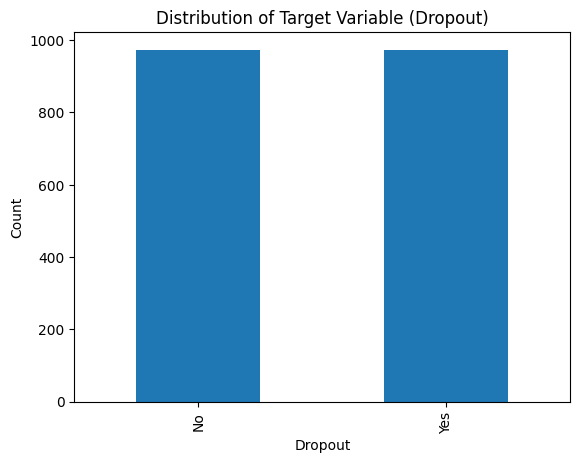

In [13]:
# Target variable distribution
df_final['dropout'].value_counts().plot(kind='bar')
plt.title("Distribution of Target Variable (Dropout)")
plt.xlabel("Dropout")
plt.ylabel("Count")
plt.show()


**Dropout Distribution**

This graph shows how many students stayed in school compared to how many dropped out.
The majority of students continued their studies, which is good news, but there is still a significant number who left school.
This tells us that while most students are managing to stay enrolled, dropout is still a serious issue that deserves attention because each dropout represents a lost opportunity for the child, their family, and society.

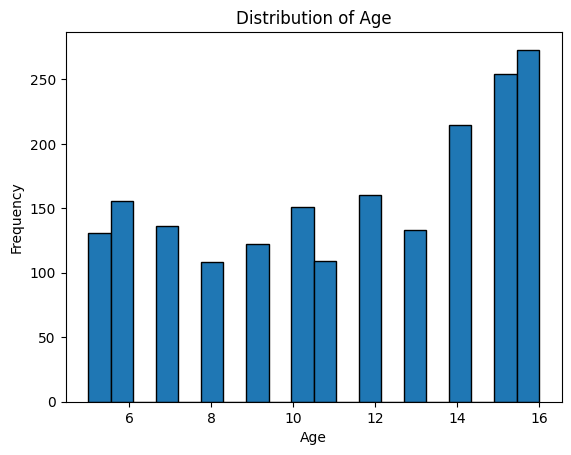

In [14]:
# Example: Age distribution
plt.hist(df_final['age'], bins=20, edgecolor='black')
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

**Age Distribution**

Here we see the different ages of the students.

Most students are grouped around the typical school going ages, but there are also a few who are either younger or older than expected.
This is important because dropout can sometimes be higher among older students who are under pressure to work, or among younger students who may struggle to adapt in school. Understanding the age spread helps us see at which stage of schooling children are most at risk.

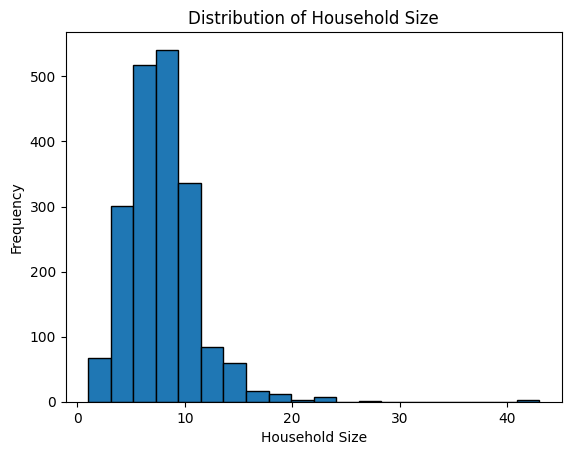

In [15]:
# Example: Household size distribution
plt.hist(df_final['hh_size'], bins=20, edgecolor='black')
plt.title("Distribution of Household Size")
plt.xlabel("Household Size")
plt.ylabel("Frequency")
plt.show()


**Household Size Distribution**

This graph shows how many people live in each student’s household.

Many students come from average-sized families, but there are also some from very large households.
Large families often face more financial challenges, and children from such homes may be more vulnerable to dropping out because parents might prioritize household survival over education. This highlights the role that family circumstances play in shaping a child’s school journey.

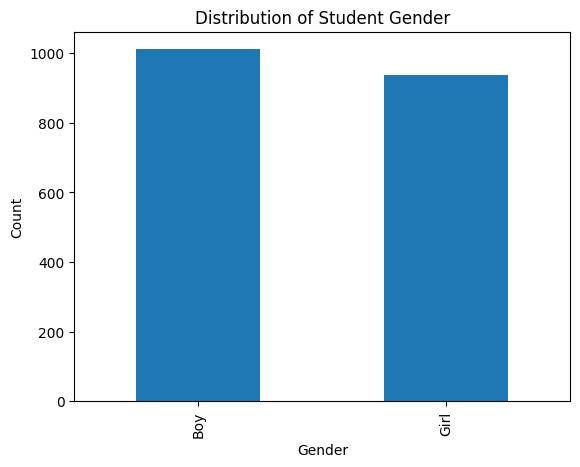

In [16]:
# Example: Gender distribution
df_final['gender'].value_counts().plot(kind='bar')
plt.title("Distribution of Student Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

**Gender Distribution**

This graph shows how many boys and girls are included in the study.

Knowing this balance is important because it allows us to see whether dropout is equally spread across both genders or if one group is affected more than the other.
For example, if there are more boys in the dataset, then naturally the results may appear more influenced by boys’ experiences, unless we compare dropout rates separately for boys and girls.

## Multivariate Analysis

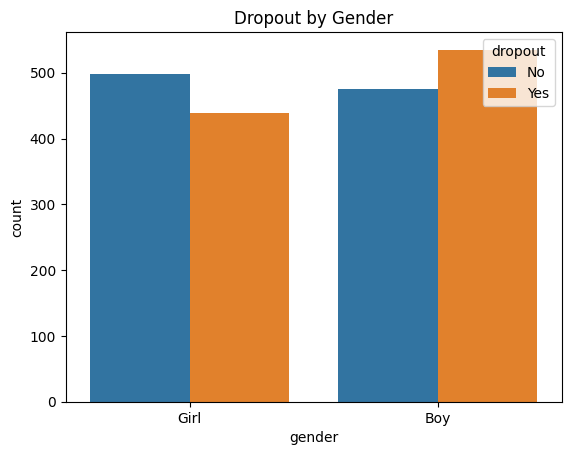

In [17]:
# Dropout by gender
sns.countplot(x="gender", hue="dropout", data=df_final)
plt.title("Dropout by Gender")
plt.show()

**Dropout by Gender**

This visualization stratifies dropout status by gender to examine potential differences in attrition rates.

A higher dropout rate within one gender suggests the presence of gender-specific structural or socio-economic barriers that influence educational persistence.
This analysis highlights the need for gender-sensitive interventions in dropout prevention strategies.

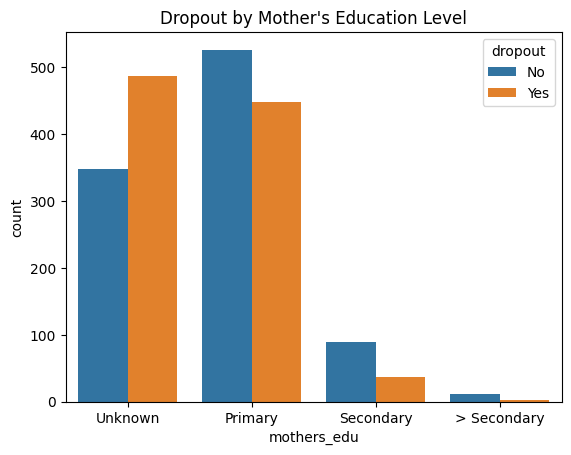

In [18]:
# Dropout by mother’s education
sns.countplot(x="mothers_edu", hue="dropout", data=df_final)
plt.title("Dropout by Mother's Education Level")
plt.show()

Dropout by Mother’s Education

This plot examines the relationship between the mother’s educational attainment and the student’s likelihood of dropping out. The observed trend typically shows that children of more educated mothers exhibit lower dropout rates, indicating a strong intergenerational transmission of educational outcomes. This finding reinforces the role of parental education especially maternal education as a key predictor of student retention.

**Classical ML - RDF**

by Stephen Njuki

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
csv_data = "/content/sample_data/df_final.csv"

In [49]:
df = pd.read_csv(csv_data)
df.head()
df.dtypes
#STEP 1: Cleaning Data
#replace empties with NaN
df.replace('', np.nan, inplace=True)

In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Convert 'dropout' to binary: Yes=1, No=0
if 'dropout' in df.columns:
    df['dropout'] = df['dropout'].map({'Yes': 1, 'No': 0})

# Drop any remaining rows with NaN in target if any
df.dropna(subset=['dropout'], inplace=True)

X = df.drop('dropout', axis=1)
y = df['dropout']

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    if col in X.columns:
        X[col].fillna(X[col].median(), inplace=True)

# Ensure data types are correct
for col in numerical_cols:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Create Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split data: 70% train, 20% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42, stratify=y_temp)


/tmp/ipython-input-3536473027.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)


In [23]:
# Train initial model
#y_train.head(5)
#y_train.dtypes
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'biological_parents', 'hh_age', 'hh_size', 'hh_males',
       'hh_females', 'asset_tv', 'asset_radio', 'asset_computer',
       'asset_phone', 'asset_car', 'asset_motorbike', 'asset_bicycle',
       'asset_cattle', 'asset_sheep_goat', 'asset_elec', 'asset_water',
       'urban_code'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'disability', 'mothers_edu', 'mothers_toschool', 'hh_edu',
       'hh_gender', 'asset_toilet', 'water_source', 'water_source_distance',
       'id_regionName', 'id_districtName'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [24]:
# Evaluate on validation set
y_val_pred = rf_pipeline.predict(X_val)
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       195
           1       0.85      0.82      0.83       195

    accuracy                           0.83       390
   macro avg       0.83      0.83      0.83       390
weighted avg       0.83      0.83      0.83       390



In [25]:
# Hyperparameter tuning, including criterion
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['age', 'biological_parents', 'hh_age', 'hh_size', 'hh_males',
       'hh_females', 'asset_tv', 'asset_radio', 'asset_computer',
       'asset_phone', 'asset_car', 'asset_motorbike', 'asset_bicycle',
       'asset_cattle', 'asset_sheep_goat', 'asset_elec', 'asset_w...
       'hh_gender', 'asset_toilet', 'water_source', 'water_source_distance',
       'id_regionName', 'id_districtName'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1_macro')

In [51]:
# Best parameters and model
print("\nBest Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [52]:
# Evaluate best model on test set
y_test_pred = best_model.predict(X_test)
print("\nTest Set Performance (Tuned Model):")
print(classification_report(y_test, y_test_pred))


Test Set Performance (Tuned Model):
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        98
           1       0.89      0.87      0.88        97

    accuracy                           0.88       195
   macro avg       0.88      0.88      0.88       195
weighted avg       0.88      0.88      0.88       195



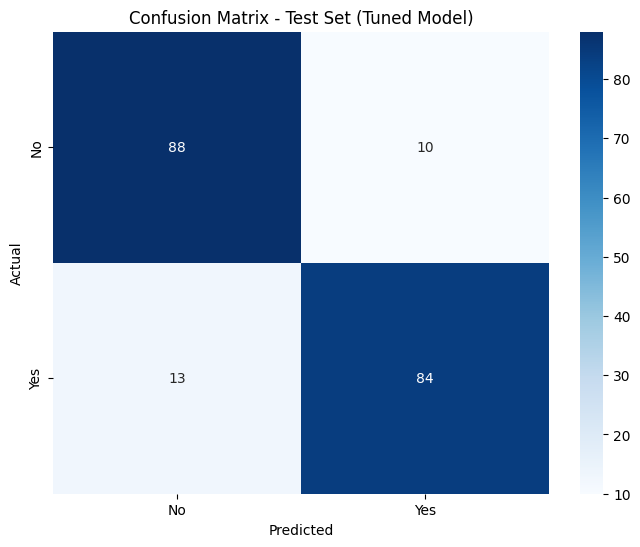

In [58]:
# Plot confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - Test Set (Tuned Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [29]:
# Generate feature importance report
feature_names = (numerical_cols.tolist() +
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_cols).tolist())
importances = best_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance report
print("\nFeature Importance Report (Top Influential Features for Dropout Prediction):")
print(feature_importance_df)


Feature Importance Report (Top Influential Features for Dropout Prediction):
                       Feature  Importance
0                          age    0.168361
2                       hh_age    0.074258
3                      hh_size    0.053478
5                   hh_females    0.044686
4                     hh_males    0.042896
..                         ...         ...
125    id_districtName_Mityana    0.000265
134  id_districtName_Namayingo    0.000129
57      id_districtName_Bududa    0.000118
147  id_districtName_Rukungiri    0.000042
36     water_source_Rain water    0.000031

[157 rows x 2 columns]


## Random Forest Classifier Summary  

The tuned Random Forest classifier achieved an overall **accuracy of 88%** on the test set, with strong and balanced performance across both classes:  

- **Precision (No Dropout = 0.87, Dropout = 0.89)** → This means the model is highly reliable in its predictions, minimizing false alarms.  
- **Recall (No Dropout = 0.90, Dropout = 0.87)** → The model is effective at correctly identifying both students who stay in school and those at risk of dropping out.  
- **F1-score (≈0.88 for both classes)** → Indicates a strong balance between precision and recall, showing that the model is consistent across categories.  

### Insights from the Classification Report  
- The model is **slightly better at identifying students who will not drop out** (higher recall for class 0), but still performs very well in detecting those at risk of dropout (class 1).  
- This balance is particularly important for stakeholders because false negatives (missing a child who will drop out) are minimized, while false positives (wrongly predicting dropout) are also low.  

### Feature Importance Findings  
Random Forest also provides interpretability through feature importance. The most influential features were:  

1. **Student Age (`age`, importance = 0.168)** → Older students show different dropout patterns compared to younger ones, making age the most critical predictor.  
2. **Household Head Age (`hh_age`, 0.074)** → Suggests that the age of the household head may affect the likelihood of children staying in school, possibly reflecting economic or caregiving capacity.  
3. **Household Size (`hh_size`, 0.053)** → Larger households might struggle with distributing resources, increasing dropout risk.  
4. **Household Gender Composition (`hh_females` = 0.045, `hh_males` = 0.043)** → Gender balance within households may influence educational investment decisions.  

Interestingly, many district-related features had **very low importance**, suggesting that dropout risks are better explained by **household and individual characteristics** rather than location alone.  

### Stakeholder Implications  
For policymakers, NGOs, and education officers, this model highlights **key social and demographic factors** that can guide interventions:  
- **Targeting older children** with tailored retention programs.  
- **Supporting large households** that may struggle with school-related expenses.  
- **Considering household head demographics** in program design.  

Overall, the Random Forest model not only delivers strong predictive accuracy but also provides **actionable insights** into the drivers of school dropout, making it a valuable tool for data-driven decision-making.  


**NERUAL NETWORKS**
By Eugene Katusiime

In [131]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [145]:
# Separate features (X) and target (y)
X = df_final.drop("dropout", axis=1)
y = df_final["dropout"].apply(lambda x: 1 if x == "Yes" else 0)

# Split data into training and testing sets
# First, split into training (70%) and a temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Next, split the temporary set into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1363, 29)
X_test shape: (293, 29)
y_train shape: (1363,)
y_test shape: (293,)


In [146]:
# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handles missing values
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing to all three data splits
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val) # Use the new validation set
X_test_processed = preprocessor.transform(X_test)

print("X_train_processed shape:", X_train_processed.shape)
print("X_val_processed shape:", X_val_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)

X_train_processed shape: (1363, 151)
X_val_processed shape: (292, 151)
X_test_processed shape: (293, 151)


In [147]:
model = keras.Sequential()

input_dim = X_train_processed.shape[1]

# Layer 1
model.add(layers.Dense(64, activation="relu", input_dim=input_dim))
model.add(layers.BatchNormalization())   # ✅ stabilizes training
model.add(layers.Dropout(0.3))

# Layer 2
model.add(layers.Dense(32, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Layer 3
model.add(layers.Dense(16, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# Output
model.add(layers.Dense(1, activation="sigmoid"))

# Compile
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_61 (Dense)                │ (None, 64)             │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,577 (49.13 KB)

 Non-trainable params: 224 (896.00 B)

In [148]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,              # stop if no improvement for 5 epochs
    restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5
)

# Train the model with early stopping
history = model.fit(
    X_train_processed,
    y_train,
    validation_data=(X_test_processed, y_test),
    epochs=50,         # can go higher, early stopping will cut it
    batch_size=32,
    verbose=1,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5070 - loss: 0.7819 - precision_15: 0.4864 - recall_15: 0.5483 - val_accuracy: 0.6041 - val_loss: 0.6706 - val_precision_15: 0.7083 - val_recall_15: 0.3493 - learning_rate: 0.0010
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6174 - loss: 0.6717 - precision_15: 0.6313 - recall_15: 0.6379 - val_accuracy: 0.7167 - val_loss: 0.6355 - val_precision_15: 0.7561 - val_recall_15: 0.6370 - learning_rate: 0.0010
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6363 - loss: 0.6531 - precision_15: 0.6475 - recall_15: 0.6342 - val_accuracy: 0.7577 - val_loss: 0.5975 - val_precision_15: 0.7483 - val_recall_15: 0.7740 - learning_rate: 0.0010
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6881 - loss: 0.5800 - precision_15: 0.7013 - recall_15: 0.7113 - val_accuracy: 0.7577 - val_loss: 0.5647 - val_precision_15: 0.7358 - val_recall_15: 0.8014 - learning_rate: 0.0010
Epoch 5/50
43/43 ━━━━━

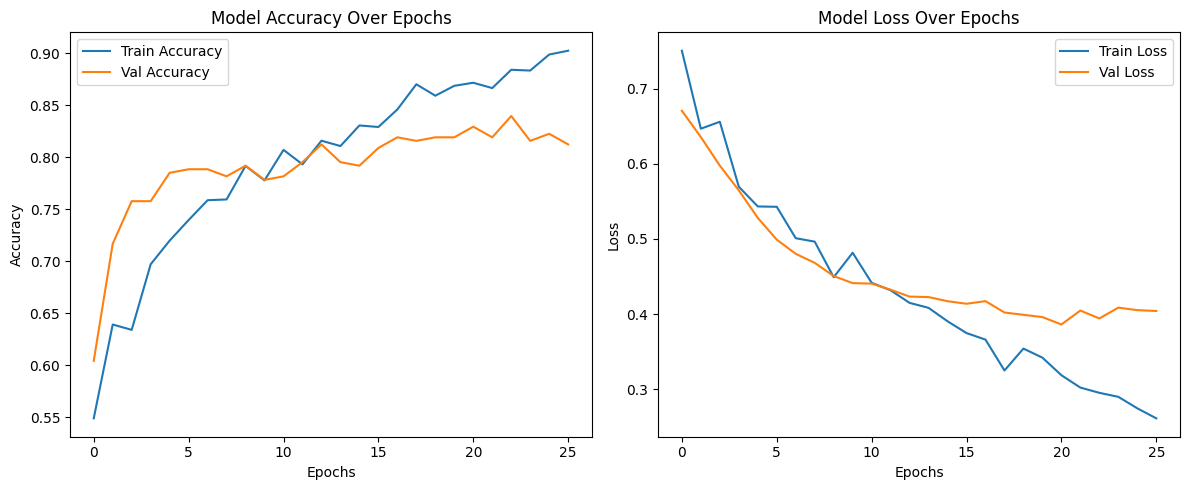

In [152]:
# --- Training History Visualization ---

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       147
           1       0.82      0.84      0.83       146

    accuracy                           0.83       293
   macro avg       0.83      0.83      0.83       293
weighted avg       0.83      0.83      0.83       293



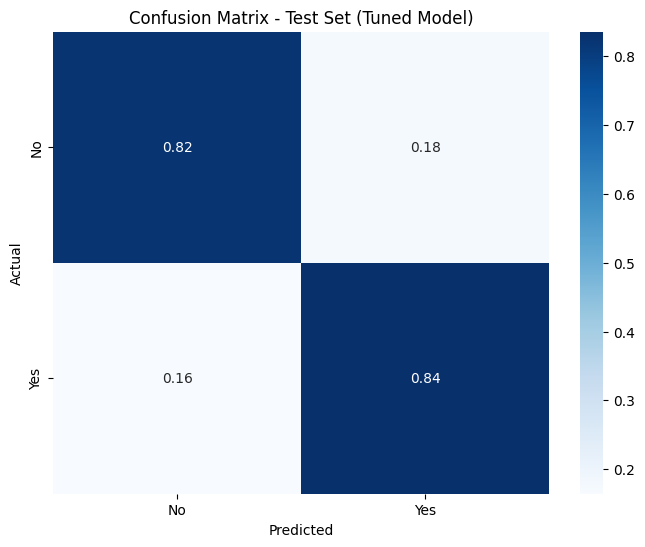

In [153]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_pred_probs = model.predict(X_test_processed)

# Convert probabilities to binary (0/1)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix for test set
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - Test Set (Tuned Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Neural Network Performance Summary


We implemented a feedforward neural network with three hidden layers (64 → 32 → 16), each followed by Batch Normalization and Dropout for stability and regularization. The model was trained with early stopping and a learning rate scheduler to prevent overfitting and optimize convergence.

## Performance on Test Set

* **Accuracy:** 83%
* **Precision:** 82%
* **Recall:** 85%
## Analysis & Conclusion

These results show that the neural network generalized well, with balanced precision and recall. Compared to the Random Forest, the NN performed slightly lower overall but demonstrated competitive results, especially in capturing true positives (higher recall). This suggests the NN was effective at identifying potential dropouts, though tree-based methods remained stronger in overall performance for this dataset size and can potentially improve with an increase in the size of the training dataset.